In [1]:
import pandas as pd

import numpy as np

In [2]:
from scipy.stats import gaussian_kde
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
import matplotlib

%matplotlib inline

In [4]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

**Analysis**

In [9]:
df = pd.read_csv('WiM_data/publications_in_mathematics.csv', index_col=0)

Total number of articles we have collected are:

In [10]:
len(df['unique_key'].unique())

19280

In [11]:
len(df['author'].unique())

27555

In [12]:
df.columns

Index(['index', 'unique_key', 'title', 'author', 'date', 'source'], dtype='object')

**Gender analysis**

The library `gender_guesser` will be used to estimate the gender of the authors. Note that the result of the library will be one of:

- unknown (name not found), 
- andy (androgynous),
- male, 
- female,
- mostly_male or
- mostly_female.

The difference between andy and unknown is that the former is found to have the same probability to be male than to be female, while the later means that the name wasn’t found in the database.

In [13]:
d = gender.Detector(case_sensitive=False)

In [14]:
d.get_gender('nikoleta')

'female'

In [15]:
def get_gender_of_author(row):
    if row['source'] == 'Springer':
        return d.get_gender(row['author'].split(' ')[-1])
    return d.get_gender(row['author'].split(' ')[0])

In [16]:
df["gender"] = df.apply(
    get_gender_of_author, axis=1
)

In [17]:
gender = df[['author', 'gender']].drop_duplicates()

In [18]:
pd.DataFrame(gender.groupby("gender").count()['author'].sort_values())

,author
gender,
mostly_female,186
mostly_male,482
female,2168
andy,3584
unknown,10144
male,10991


In [19]:
num_authors = pd.DataFrame(df.groupby(['unique_key', 'author'], as_index=False
                             ).size().groupby(['unique_key']).count())

In [20]:
num_authors = num_authors.rename(columns={0: 'num_authors'}).reset_index()

In [21]:
df = pd.merge(df, num_authors, on=['unique_key'], how='inner')

In [22]:
grouped = df.groupby(['unique_key', 'gender'], as_index=False
                             ).count()

In [23]:
df.num_authors.sort_values().unique()[-5:]

array([13, 14, 15, 18, 33])

In [24]:
key_to_drop = df[df.num_authors == 33].unique_key.unique()[0]

In [25]:
df = df[~(df['unique_key'] == key_to_drop)]

**Females**

In [26]:
def get_number_of_genders_per_article(df, grouped):
    
    for gender in ['female', 'male', 'mostly_female', 'mostly_male']:
        gender_counts = grouped[grouped['gender'] == gender][['unique_key','title']]
        gender_counts = gender_counts.rename(columns={'title':'%s_count' % gender})
        
        df = pd.merge(df, gender_counts, on=['unique_key'], how='outer')
    
    df = df.fillna(0)
    df['female_authors'] = df['female_count'] + df['mostly_female_count']
    df['male_authors'] = df['male_count'] + df['mostly_male_count']
        
    return df

In [27]:
df = get_number_of_genders_per_article(df, grouped)

In [28]:
def get_female_ratio(row):
    return row['female_authors'] / row['num_authors']
def get_male_ratio(row):
    return row['male_authors'] / row['num_authors']

In [29]:
df = df[~(df['num_authors'] == 0)]

In [37]:
papers = df.drop_duplicates(subset='unique_key', keep="last")

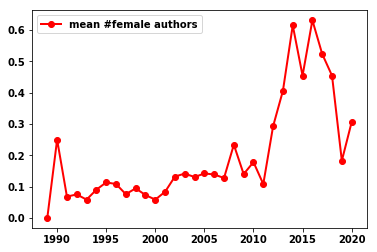

In [38]:
fig, axes = plt.subplots()

plt.plot(papers.groupby('date').mean()['female_authors'], '-o',
         label='mean #female authors', color='red', linewidth=2);

plt.legend();

plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/number_of_authors_per_year.png')

In [39]:
df["female_ratio"] = df.apply(
    get_female_ratio, axis=1
)

In [40]:
df["male_ratio"] = df.apply(
    get_male_ratio, axis=1
)

In [41]:
df['female_ratio'].describe()

count    37915.000000
mean         0.076012
std          0.197166
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: female_ratio, dtype: float64

In [42]:
papers['female_ratio'].describe()

count    19279.000000
mean         0.072047
std          0.210853
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: female_ratio, dtype: float64

In [43]:
df['male_ratio'].describe()

count    37915.000000
mean         0.454754
std          0.423284
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: male_ratio, dtype: float64

In [44]:
papers['male_ratio'].describe()

count    19279.000000
mean         0.497612
std          0.447760
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: male_ratio, dtype: float64

In [45]:
t_stat, p_val = stats.ttest_ind(df['female_ratio'], df['male_ratio'], equal_var=False)

In [46]:
p_val

0.0

A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

In [47]:
color = matplotlib.cm.plasma(np.linspace(0, 1, 1))

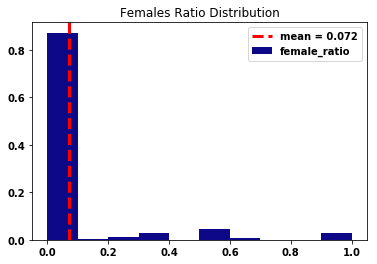

In [53]:
fig, ax = plt.subplots();
plt.title('Females Ratio Distribution')

weights = np.ones_like(papers['female_ratio']) / float(len(papers['female_ratio']))
ax.hist(papers['female_ratio'], color=color, weights=weights);
ax.axvline(np.mean(papers['female_ratio']), c='red',
           label ="mean = %s" %round(np.mean(papers['female_ratio']), 3),
           linestyle='--', linewidth=3);

plt.legend();

plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/female_ratio_distribution.png')

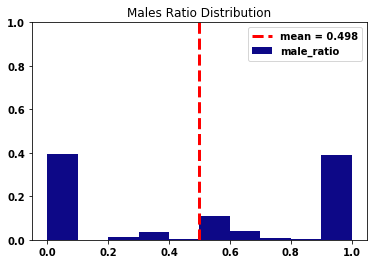

In [65]:
fig, ax = plt.subplots();
plt.title('Males Ratio Distribution')


weights = np.ones_like(papers['male_ratio']) / float(len(papers['male_ratio']))
ax.hist(papers['male_ratio'], color=color, weights=weights);
ax.axvline(np.mean(papers['male_ratio']), c='red',
           label ="mean = %s" %round(np.mean(papers['male_ratio']), 3),
           linestyle='--', linewidth=3);

plt.legend();

ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/male_ratio_distribution.png')

**Same but removing zeros**

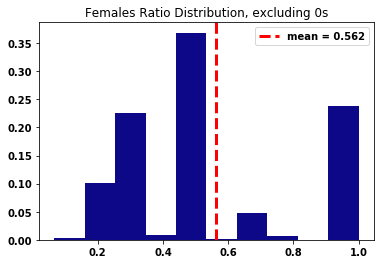

In [68]:
x = [val for val in papers['female_ratio'] if val !=0]

fig, ax = plt.subplots();

weights = np.ones_like(x) / float(len(x))
plt.hist(x, color=color, weights=weights);

plt.title('Females Ratio Distribution, excluding 0s')
plt.axvline(np.mean(x), c='red',
           label ="mean = %s" %round(np.mean(x), 3),
           linestyle='--', linewidth=3);

plt.legend();
plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/female_ratio_distribution_excl_zeros.png')

/home/nightwing/anaconda3/envs/arcas/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


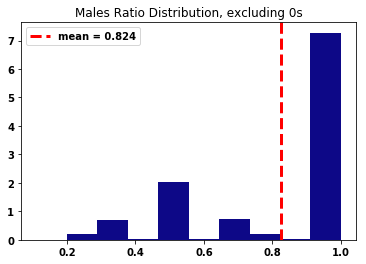

In [80]:
y = [val for val in papers['male_ratio'] if val !=0]

fig, ax = plt.subplots();
plt.hist(y, color=color, normed=True)
plt.title('Males Ratio Distribution, excluding 0s')
plt.axvline(np.mean(y), c='red',
           label ="mean = %s" %round(np.mean(y), 3),
           linestyle='--', linewidth=3);

plt.legend();
plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/male_ratio_distribution_excl_zeros.png')

In [99]:
t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)
p_val < 0.05

True

In [100]:
with_female_ratio = papers[['female_ratio', 'date', 'num_authors']]

In [101]:
with_male_ratio = papers[['male_ratio', 'date', 'num_authors']]

In [102]:
without_zeros = with_female_ratio[with_female_ratio['female_ratio'] != 0]

In [103]:
xy = np.vstack([without_zeros['num_authors'], without_zeros['female_ratio']])
z = gaussian_kde(xy)(xy)

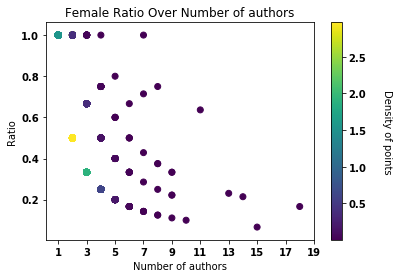

In [104]:
fig, ax = plt.subplots()

plt.scatter(without_zeros['num_authors'], without_zeros['female_ratio'], c=z);
plt.title('Female Ratio Over Number of authors')

ax.set_xticks(range(1, 20, 2))
ax.set_ylabel('Ratio')
ax.set_xlabel('Number of authors')
cbar = plt.colorbar();
cbar.ax.get_yaxis().labelpad = 25
cbar.set_label('Density of points', rotation=270)

plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/scatter_plot_female_ratio_num_authors.png')

In [105]:
without_zeros_males = with_male_ratio[with_male_ratio['male_ratio'] != 0]

In [106]:
xy = np.vstack([without_zeros_males['num_authors'], without_zeros_males['male_ratio']])
z = gaussian_kde(xy)(xy)

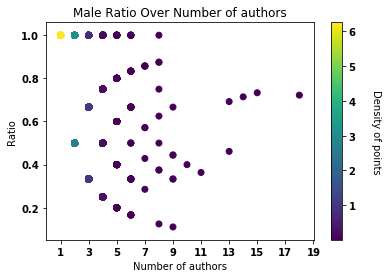

In [107]:
fig, ax = plt.subplots()

ax.set_xticks(range(1, 20, 2))
ax.set_ylabel('Ratio')
ax.set_xlabel('Number of authors')

plt.scatter(without_zeros_males['num_authors'], without_zeros_males['male_ratio'], c=z);
plt.title('Male Ratio Over Number of authors')
cbar = plt.colorbar();
cbar.ax.get_yaxis().labelpad = 25
cbar.set_label('Density of points', rotation=270)

plt.savefig('../src/www/Nikoleta-v3.github.io/assets/images/scatter_plot_male_ratio_num_authors.png')

In [108]:
total = papers[papers['female_ratio'] == 1].count().values[0]

In [122]:
papers[papers['female_ratio'] == 1].groupby('num_authors').count()['index']

num_authors
1.0    457
2.0    117
3.0     12
4.0      1
7.0      1
Name: index, dtype: int64

In [109]:
papers[papers['female_ratio'] == 1].groupby('num_authors').count()['index'] / total * 100

num_authors
1.0    77.721088
2.0    19.897959
3.0     2.040816
4.0     0.170068
7.0     0.170068
Name: index, dtype: float64

In [110]:
papers[papers['female_ratio'] == 1].groupby('num_authors').count()['index']

num_authors
1.0    457
2.0    117
3.0     12
4.0      1
7.0      1
Name: index, dtype: int64

In [111]:
total = papers[papers['male_ratio'] == 1].count().values[0]

In [123]:
papers[papers['male_ratio'] == 1].groupby('num_authors').count()['index']

num_authors
1.0    4545
2.0    2244
3.0     589
4.0     125
5.0      14
6.0       7
8.0       1
Name: index, dtype: int64

In [112]:
papers[papers['male_ratio'] == 1].groupby('num_authors').count()['index'] / total * 100

num_authors
1.0    60.398671
2.0    29.820598
3.0     7.827243
4.0     1.661130
5.0     0.186047
6.0     0.093023
8.0     0.013289
Name: index, dtype: float64

In [113]:
papers[papers['male_ratio'] == 1].groupby('num_authors').count()['index']

num_authors
1.0    4545
2.0    2244
3.0     589
4.0     125
5.0      14
6.0       7
8.0       1
Name: index, dtype: int64

In [114]:
papers[papers['unique_key'] == '01ba68386d723c3af56b171911aac3b2']['title'].values

array(['Modular invariants for genus 3 hyperelliptic curves'],
      dtype=object)

In [115]:
df[(df['source'] == 'arxiv') & (df['female_ratio'] != 0)]['female_ratio'].describe()

count    2046.000000
mean        0.513685
std         0.245846
min         0.066667
25%         0.333333
50%         0.500000
75%         0.500000
max         1.000000
Name: female_ratio, dtype: float64

In [116]:
df[(df['source'] == 'Springer') & (df['female_ratio'] != 0)]['female_ratio'].describe()

count    3899.000000
mean        0.447038
std         0.224128
min         0.111111
25%         0.333333
50%         0.333333
75%         0.500000
max         1.000000
Name: female_ratio, dtype: float64

In [72]:
df = df.drop(columns=['index', "female_count", "male_count", "mostly_female_count", "mostly_male_count"])

In [73]:
df.to_csv('WiM_data/publications_in_mathematics.csv')